### Learning Vector Quantization (LVQ)
This notebook template implements the Learning Vector Quantization (LVQ) algorithm. This is using another library - Scikit-learning vector quantization (sklvq) - that integrates with sklearn. 

This particular ML algorithm is a new one for me as was not covered in the past, but was part of an ebook exercise in refreshing for artificial neural networks topic as a precursor to refresher on deep learning and thesis project. Some interesting background below:

Background
- https://en.wikipedia.org/wiki/Learning_vector_quantization
- https://en.wikipedia.org/wiki/Teuvo_Kohonen

Referenced library documentation:
- sklvq - https://sklvq.readthedocs.io/en/stable/index.html

This notebook does re-use the Gradio UI function provided in the course examples from the serverless-ml course from featurestore.org for Iris dataset as that is a really useful UI mock-up tool for working with stakeholders in any ML project at prototype phase.

Remember: While this is similar in some ways to KNN in use of a distance metric, unlike KNN, which does not generate a model in that classic ML sense, LVQ does produce a model.

It predicts one of three response variables e.g. Iris-setosa, Iris-Versicolour, Iris-Virginica.

Import pandas, sklearn and additional libraries for Label Encoding for the response variable - we will convert the categoric output label (text label of flower variety) to a numeric encoding. We will again use the train:test split library and import our k-nearest-neighbors library from sklearn. And we will import the standard evaluation metric reporting libraries and data visualization plotting tools.

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklvq import GLVQ
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

# using template header from sklvq basic usage example code for lvq - refer here to Web Reference:
# https://sklvq.readthedocs.io/en/stable/auto_examples/04_performance_metrics/plot_01_learning_rate_lvq.html
matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

The next cell re-uses the ProcessLogger class in the sklvq documentation guide section - "Learning Behaviour". We re-use their same how-to code for generation of the learning curve using this ProcessLogger with callback function later in the performance monitoring section.
- https://sklvq.readthedocs.io/en/stable/auto_examples/04_performance_metrics/plot_01_learning_rate_lvq.html

In [2]:
# https://sklvq.readthedocs.io/en/stable/auto_examples/04_performance_metrics/plot_01_learning_rate_lvq.html
class ProcessLogger:
    def __init__(self):
        self.states = np.array([])

    # A callback function has to accept two arguments, i.e., model and state, where model is the
    # current model, and state contains a number of the optimizers variables.
    def __call__(self, state):
        self.states = np.append(self.states, state)
        return False  # The callback function can also be used to stop training early,
        # if some condition is met by returning True.


# Initiate the "logger".
logger = ProcessLogger()

#### EDA, ML Model training
For more information on the dataset source, refer to the below link from Kaggle datasets:
- https://www.kaggle.com/datasets/uciml/iris

In [3]:
iris_df = pd.read_csv("../datasets/Iris.csv")

In [4]:
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [6]:
iris_df.shape

(150, 6)

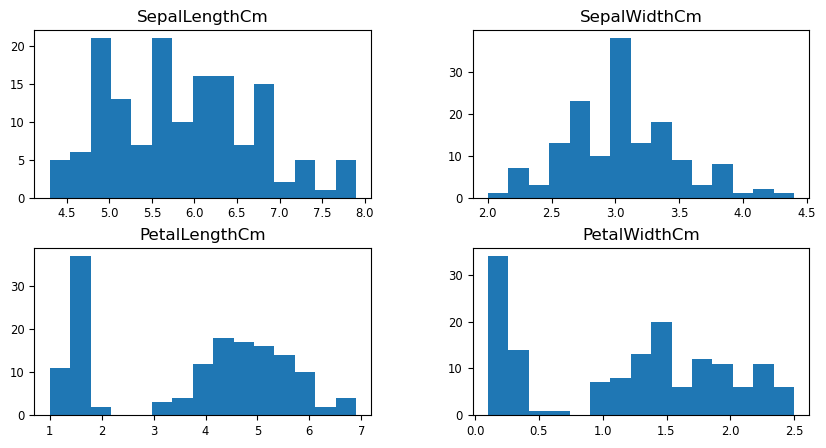

In [7]:
# eda obtains the features from the dataframe 
features_no_output_label = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
iris_df[features_no_output_label].hist(bins=15, figsize=(10, 5), layout=(2, 2), grid=False);

In [8]:
iris_df.size

900

In [9]:
iris_df.ndim

2

In [10]:
# the .T renders the transpose of the output table from describe; sometimes a bit easier to read when you flip the
# table from rows to statistical summary as columns like below
iris_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,150.0,75.500000,43.445368,1.0,38.25,75.50,112.75,150.0
SepalLengthCm,150.0,5.843333,0.828066,4.3,5.10,5.80,6.40,7.9
SepalWidthCm,150.0,3.054000,0.433594,2.0,2.80,3.00,3.30,4.4
PetalLengthCm,150.0,3.758667,1.764420,1.0,1.60,4.35,5.10,6.9
PetalWidthCm,150.0,1.198667,0.763161,0.1,0.30,1.30,1.80,2.5


In [11]:
iris_df.sample(n=5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
98,99,5.1,2.5,3.0,1.1,Iris-versicolor
32,33,5.2,4.1,1.5,0.1,Iris-setosa
14,15,5.8,4.0,1.2,0.2,Iris-setosa
109,110,7.2,3.6,6.1,2.5,Iris-virginica
1,2,4.9,3.0,1.4,0.2,Iris-setosa


Verify if any null values in the dataframe for a given data column.

In [12]:
iris_df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [13]:
X = iris_df.iloc[: , 1:5]

In [14]:
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [15]:
# data preprocessing: convert the categoric variables to numeric format
label_encoder = LabelEncoder()
iris_df['Species']= label_encoder.fit_transform(iris_df['Species'])

Refer to the Species column and see the label output is now in range 0, 1, and 2 for the 3 flower varieties.

In [16]:
iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [17]:
y = iris_df.iloc[: , -1]

In [18]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: int64

In [19]:
scaler = StandardScaler()
scaler

StandardScaler()

In [20]:
X = scaler.fit_transform(X)
X

array([[-9.00681170e-01,  1.03205722e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00, -1.24957601e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.38535265e+00,  3.37848329e-01, -1.39813811e+00,
        -1.31297673e+00],
       [-1.50652052e+00,  1.06445364e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.02184904e+00,  1.26346019e+00, -1.34127240e+00,
        -1.31297673e+00],
       [-5.37177559e-01,  1.95766909e+00, -1.17067529e+00,
        -1.05003079e+00],
       [-1.50652052e+00,  8.00654259e-01, -1.34127240e+00,
        -1.18150376e+00],
       [-1.02184904e+00,  8.00654259e-01, -1.28440670e+00,
        -1.31297673e+00],
       [-1.74885626e+00, -3.56360566e-01, -1.34127240e+00,
        -1.31297673e+00],
       [-1.14301691e+00,  1.06445364e-01, -1.28440670e+00,
        -1.44444970e+00],
       [-5.37177559e-01,  1.49486315e+00, -1.28440670e+00,
        -1.31297673e+00],
       [-1.26418478e+00,  8.00654259e-01, -1.22754100e+00,
      

##### Create a train:test split on the dataset
Next, we define our train:test split using sklearn library. This lets us defined our supervised learning training set and a holdout test data subset. We will use a 33% portion of the dataset as a test set. We will use this to test the accuracy of the ML model on data it has not seen before in training and if it has overfit during training or can generalize to unseen data.

In [21]:
# split into train and test sets with sklearn native train_test_split 33% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [22]:
X_train.shape

(100, 4)

In [23]:
X_test.shape

(50, 4)

##### Machine Learning Model and Training
Define our LVQ machine learning implementation using the corresponding sklvq implementation library.

Couple of parameters to consider here, which will be somewhat similar to when constructing an artificial neural network model:
- learning rate (alpha)
- number of codebooks
- number of epochs

In [24]:
# define LVQ model: below parameter step_size and max_runs will have significant impact on performance of ML model
# based on offline equations example, started with 0.1, then 0.3 and best performance so far is 0.2 with max epochs
# at 30
lvq_clf = GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 30, "step_size": 0.2, "callback": logger},
)

We are following the initial parameters from the sksklvq api documentation and usage examples. I have tested other starting point values too with good performance. Leaving with defaults as good baseline for now on this dataset. 

We have a few activation functions available, swish function demonstrated in their usage example. For more background, refer here: - https://en.wikipedia.org/wiki/Swish_function

In [25]:
lvq_clf.fit(X_train, y_train)

GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'callback': <__main__.ProcessLogger object at 0x7fc52d520b80>,
                    'max_runs': 30, 'step_size': 0.2})

##### LVQ Algorithm: Run Predictions, Evaluate Performance

In [26]:
# run prediction on test dataset
lvq_clf.predict(X_test)

array([0, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0,
       2, 2, 0, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       2, 0, 2, 2, 0, 0])

In [27]:
y_pred = lvq_clf.predict(X_test)
metrics = classification_report(y_test, y_pred, output_dict=False)

In [28]:
print(metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.95      0.97        19
           2       0.94      1.00      0.97        15

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [29]:
cm = confusion_matrix(y_test, y_pred)

In [30]:
cm

array([[16,  0,  0],
       [ 0, 18,  1],
       [ 0,  0, 15]])

Below is a useful sklearn confusion matrix display utility plot. I always refer to it ever I need to check the array dimensions for true label, predicted labels. Seaborn is used later for an alternative display plot with text labels.

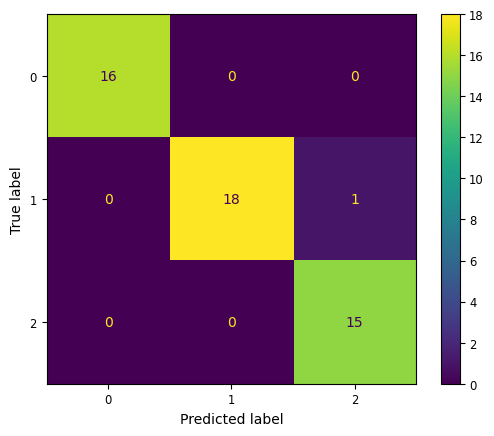

In [31]:
ConfusionMatrixDisplay(cm).plot()

<AxesSubplot:>

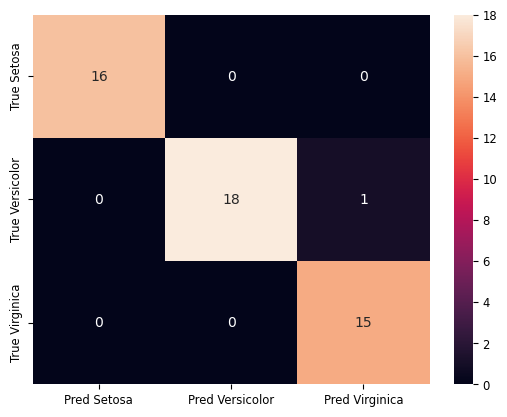

In [32]:
df_confusion_matrix = pd.DataFrame(cm, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

sns.heatmap(df_confusion_matrix, annot=True)

We will include a learning curve for this ML model. This is using the template code from basic usage the basic sklvq documentation example found here:
- https://sklvq.readthedocs.io/en/stable/auto_examples/04_performance_metrics/plot_01_learning_rate_lvq.html

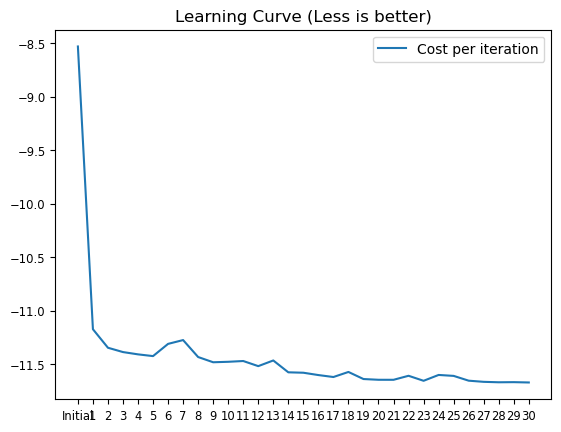

In [33]:
# https://sklvq.readthedocs.io/en/stable/auto_examples/04_performance_metrics/plot_01_learning_rate_lvq.html
# logger.states - for debugging logger array contents
iteration, fun = zip(*[(state["nit"], state["fun"]) for state in logger.states])

ax = plt.axes()

ax.set_title("Learning Curve (Less is better)")
ax.plot(iteration, fun)
_ = ax.legend(["Cost per iteration"])

##### Gradio User Interface Layer
In this section, we add a user interface layer. While we can create synthetic data functions in Python code to test the ML model, it helps for a human stakeholder to be able to test out a machine learning model in a web browser, especially when evaluating a prototype. This was a really nice utility demonstrated on the [serverless-ml MLOps](https://github.com/niallguerin/serverless-ml-course/tree/main/src/01-module) course. The only amendment I made is to point it to my own cloned GitHub repository to retrieve the image of the flower variety. I also set share attribute to False, so it just runs the Gradio UI locally.

In [34]:
# reuses template code from the serverless-ml course module 1 to scaffold the gradio UI
import gradio as gr
import numpy as np
from PIL import Image
import requests

def convert_label(label_num):
    if(label_num == 0):
        return "Setosa"
    if(label_num == 1):
        return "Versicolor"
    if(label_num == 2):
        return "Virginica"

def iris(sepal_length, sepal_width, petal_length, petal_width):
    input_list = []
    input_list.append(sepal_length)
    input_list.append(sepal_width)
    input_list.append(petal_length)
    input_list.append(petal_width)
    # 'res' is a list of predictions returned as the label.
    res = lvq_clf.predict(np.asarray(input_list).reshape(1, -1))
    # We add '[0]' to the result of the transformed 'res', because 'res' is a list, and we only want 
    # the first element.
    flower_type = convert_label(res)
    flower_url = "https://raw.githubusercontent.com/niallguerin/serverless-ml-course/main/src/01-module/assets/" + flower_type + ".png"
    img = Image.open(requests.get(flower_url, stream=True).raw)            
    return img
        
demo = gr.Interface(
    fn=iris,
    title="Iris Flower Predictive Analytics using Learning Vector Quantization",
    description="Experiment with sepal/petal lengths/widths to predict the flower variety.",
    allow_flagging="never",
    inputs=[
        gr.inputs.Number(default=1.0, label="sepal length (cm)"),
        gr.inputs.Number(default=1.0, label="sepal width (cm)"),
        gr.inputs.Number(default=1.0, label="petal length (cm)"),
        gr.inputs.Number(default=1.0, label="petal width (cm)"),
        ],
    outputs=gr.Image(type="pil"))

demo.launch(share=False)

/Users/niallguerin/opt/anaconda3/lib/python3.9/site-packages/gradio/inputs.py:58: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/niallguerin/opt/anaconda3/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fc535143e80>, 'http://127.0.0.1:7867/', None)

#### Web References
- https://sklvq.readthedocs.io/en/stable/index.html
- https://sklvq.readthedocs.io/en/stable/auto_examples/index.html
- https://sklvq.readthedocs.io/en/stable/generated/sklvq.solvers.SteepestGradientDescent.html
- https://sklvq.readthedocs.io/en/stable/generated/sklvq.models.GLVQ.html
- https://github.com/featurestoreorg/serverless-ml-course
- https://gradio.app/docs/